In [1]:
from hockey_rink import NHLRink
import requests
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import pytz
from matplotlib.lines import Line2D
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [2]:
# Daily Games since 12/26/24 - 1/18/25


# Initialize the DataFrame
daily_games = pd.DataFrame()

base_url = "https://api-web.nhle.com/v1/schedule/"
start_date = datetime.strptime("2024-10-04", "%Y-%m-%d")
end_date = datetime.strptime("2025-04-17", "%Y-%m-%d")


current_date = start_date

# Set to keep track of unique dates
seen_dates = set()

while current_date <= end_date:
    # Format the date as 'YYYY-MM-DD'
    formatted_date = current_date.strftime("%Y-%m-%d")
    api_url = f"{base_url}{formatted_date}"

    # Make the API request
    response = requests.get(api_url)

    if response.status_code == 200:
        # The response content can be accessed using response.text
        response_text = response.text
    # pprint(response_text)
    else:
        print(f"Request failed with status code {response.status_code}")

    json_data = json.loads(response_text)

    game_week = json_data["gameWeek"]
    game_week_df = pd.DataFrame(game_week)

    game_week_df = game_week_df[game_week_df["numberOfGames"] != 0]

    # Filter out rows with duplicate dates
    if formatted_date not in seen_dates:
        seen_dates.add(formatted_date)
        daily_games = pd.concat([daily_games, game_week_df], ignore_index=True)
    else:
        print(f"Failed to retrieve data for {formatted_date}")

    # Move to the next week
    current_date += timedelta(weeks=1)
    # Filter out rows where 'date' is after the end date
    daily_games["date"] = pd.to_datetime(daily_games["date"])
    daily_games = daily_games[daily_games["date"] <= end_date]

    # Reset index after filtering
    daily_games.reset_index(drop=True, inplace=True)

    game_week_details = pd.json_normalize(daily_games["games"])


In [3]:
# in order to extract the data properly, it needs to be stored in a dictionary. This extracts each of the games from the cells

dfs = {}

# Loop through the iterations (30 times)
for i in range(0, len(game_week_details.columns)):
    api_response = game_week

    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_week_details[i])

        # Create a DataFrame for this iteration
        df_name = f"game_test{i}"  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")

# Then I combine all of the dfs in the list by concatenation to create a single df. now all of the game data is spread out across each row.
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df.dropna(how="all", inplace=True)


In [4]:
combined_df = combined_df[
    [
        "id",
        "season",
        "startTimeUTC",
        "gameType",
        "awayTeam.id",
        "awayTeam.abbrev",
        "awayTeam.logo",
        "homeTeam.id",
        "homeTeam.abbrev",
        "homeTeam.logo",
        "homeTeam.placeName.default",
        "awayTeam.placeName.default",
        "awayTeam.score",
        "homeTeam.score",
        "winningGoalScorer.playerId",
        "winningGoalie.playerId",
        "gameState",
    ]
]


combined_df = combined_df.convert_dtypes()
combined_df["id"] = combined_df["id"].astype(str)

combined_df["link"] = (
    "https://api-web.nhle.com/v1/gamecenter/" + combined_df["id"] + "/play-by-play"
)

# Assuming '<NA>' is a string, replace it with np.nan
combined_df["id"] = combined_df["id"].replace("<NA>", np.nan)

# Drop rows with NaN values in the 'link' column
combined_df = combined_df.dropna(subset=["id"])
combined_df = combined_df.query('gameState == "OFF"')
combined_df["startTimeUTC"] = pd.to_datetime(combined_df["startTimeUTC"])
combined_df = combined_df.rename(columns={"id": "game_id"})
combined_df = combined_df.sort_values("game_id").reset_index()


# Specify the UTC time zone
utc_timezone = pytz.utc

# Specify the target time zone (Eastern Time)
eastern_timezone = pytz.timezone("America/New_York")

# Convert 'startTimeUTC' to Eastern Time
combined_df["game_date_time"] = combined_df["startTimeUTC"].dt.tz_convert(
    eastern_timezone
)
combined_df["game_date_time"] = pd.to_datetime(combined_df["game_date_time"])
combined_df["start_time"] = (
    combined_df["game_date_time"].dt.strftime("%I:%M %p").str.lstrip("0").str.lower()
)
combined_df["game_date"] = combined_df["game_date_time"].dt.strftime("%Y-%m-%d")
combined_df.drop("startTimeUTC", axis=1, inplace=True)
# combined_df = combined_df[combined_df['game_date'] == formatted_date]
combined_df.sort_values(by="game_id")
# print("combined_df done")
combined_df.head()


,index,game_id,season,gameType,awayTeam.id,awayTeam.abbrev,awayTeam.logo,homeTeam.id,homeTeam.abbrev,homeTeam.logo,homeTeam.placeName.default,awayTeam.placeName.default,awayTeam.score,homeTeam.score,winningGoalScorer.playerId,winningGoalie.playerId,gameState,link,game_date_time,start_time,game_date
0,0,2024020001,20242025,2,1,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,7,BUF,https://assets.nhle.com/logos/nhl/svg/BUF_ligh...,Buffalo,New Jersey,4,1,8480192,8474593,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-04 13:00:00-04:00,1:00 pm,2024-10-04
1,1,2024020002,20242025,2,7,BUF,https://assets.nhle.com/logos/nhl/svg/BUF_ligh...,1,NJD,https://assets.nhle.com/logos/nhl/svg/NJD_ligh...,New Jersey,Buffalo,1,3,8481032,8474596,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-05 10:00:00-04:00,10:00 am,2024-10-05
2,3,2024020003,20242025,2,19,STL,https://assets.nhle.com/logos/nhl/svg/STL_ligh...,55,SEA,https://assets.nhle.com/logos/nhl/svg/SEA_ligh...,Seattle,St. Louis,3,2,8479385,8476412,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 16:30:00-04:00,4:30 pm,2024-10-08
3,187,2024020004,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,13,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,Florida,Boston,4,6,8479981,8475683,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 19:00:00-04:00,7:00 pm,2024-10-08
4,371,2024020005,20242025,2,16,CHI,https://assets.nhle.com/logos/nhl/svg/CHI_ligh...,59,UTA,https://assets.nhle.com/logos/nhl/svg/UTA_ligh...,Utah,Chicago,2,5,8480849,8478971,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 22:00:00-04:00,10:00 pm,2024-10-08


In [5]:
all_game_ids = combined_df["game_id"].tolist()
all_game_ids

['2024020001',
 '2024020002',
 '2024020003',
 '2024020004',
 '2024020005',
 '2024020006',
 '2024020007',
 '2024020008',
 '2024020009',
 '2024020010',
 '2024020011',
 '2024020012',
 '2024020013',
 '2024020014',
 '2024020015',
 '2024020016',
 '2024020017',
 '2024020018',
 '2024020019',
 '2024020020',
 '2024020021',
 '2024020022',
 '2024020023',
 '2024020024',
 '2024020025',
 '2024020026',
 '2024020027',
 '2024020028',
 '2024020029',
 '2024020030',
 '2024020031',
 '2024020032',
 '2024020033',
 '2024020034',
 '2024020035',
 '2024020036',
 '2024020037',
 '2024020038',
 '2024020039',
 '2024020040',
 '2024020041',
 '2024020042',
 '2024020043',
 '2024020044',
 '2024020045',
 '2024020046',
 '2024020047',
 '2024020048',
 '2024020049',
 '2024020050',
 '2024020051',
 '2024020052',
 '2024020053',
 '2024020054',
 '2024020055',
 '2024020056',
 '2024020057',
 '2024020058',
 '2024020059',
 '2024020060',
 '2024020061',
 '2024020062',
 '2024020063',
 '2024020064',
 '2024020065',
 '2024020066',
 '20240200

In [6]:
# Find the Bruins Games
bruins_games = combined_df[
    (combined_df["awayTeam.id"] == 6) | (combined_df["homeTeam.id"] == 6)
]
bruins_games.head()

,index,game_id,season,gameType,awayTeam.id,awayTeam.abbrev,awayTeam.logo,homeTeam.id,homeTeam.abbrev,homeTeam.logo,homeTeam.placeName.default,awayTeam.placeName.default,awayTeam.score,homeTeam.score,winningGoalScorer.playerId,winningGoalie.playerId,gameState,link,game_date_time,start_time,game_date
3,187,2024020004,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,13,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,Florida,Boston,4,6,8479981,8475683,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-08 19:00:00-04:00,7:00 pm,2024-10-08
10,5,2024020011,20242025,2,8,MTL,https://assets.nhle.com/logos/nhl/svg/MTL_ligh...,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,Boston,Montréal,4,6,8481043,8480280,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-10 19:00:00-04:00,7:00 pm,2024-10-10
23,7,2024020024,20242025,2,26,LAK,https://assets.nhle.com/logos/nhl/svg/LAK_ligh...,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,Boston,Los Angeles,1,2,8477956,8480280,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-12 13:00:00-04:00,1:00 pm,2024-10-12
41,9,2024020042,20242025,2,13,FLA,https://assets.nhle.com/logos/nhl/svg/FLA_ligh...,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,Boston,Florida,4,3,8482113,8475683,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-14 13:00:00-04:00,1:00 pm,2024-10-14
58,379,2024020059,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,21,COL,https://assets.nhle.com/logos/nhl/svg/COL_ligh...,Colorado,Boston,5,3,8476854,8476914,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-10-16 21:30:00-04:00,9:30 pm,2024-10-16


In [7]:
# recent bruins games

bruins_games["game_date"] = pd.to_datetime(bruins_games["game_date"], format="%Y-%m-%d")

start_date = pd.to_datetime("2024-12-26", format="%Y-%m-%d")
end_date = pd.to_datetime("2025-01-22", format="%Y-%m-%d")

# Filter the DataFrame
recent_bruins_games = bruins_games[
    (bruins_games["game_date"] >= start_date) & (bruins_games["game_date"] <= end_date)
]


recent_bruins_games.head()

,index,game_id,season,gameType,awayTeam.id,awayTeam.abbrev,awayTeam.logo,homeTeam.id,homeTeam.abbrev,homeTeam.logo,homeTeam.placeName.default,awayTeam.placeName.default,awayTeam.score,homeTeam.score,winningGoalScorer.playerId,winningGoalie.playerId,gameState,link,game_date_time,start_time,game_date
560,631,2024020561,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,29,CBJ,https://assets.nhle.com/logos/nhl/svg/CBJ_ligh...,Columbus,Boston,2,6,8477497,8478007,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-12-27 19:00:00-05:00,7:00 pm,2024-12-27
569,816,2024020570,20242025,2,29,CBJ,https://assets.nhle.com/logos/nhl/svg/CBJ_ligh...,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,Boston,Columbus,0,4,8479638,8480280,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-12-28 19:00:00-05:00,7:00 pm,2024-12-28
588,83,2024020589,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,15,WSH,https://assets.nhle.com/logos/nhl/svg/WSH_seco...,Washington,Boston,1,3,8479345,8480313,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2024-12-31 12:30:00-05:00,12:30 pm,2024-12-31
603,269,2024020604,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,3,NYR,https://assets.nhle.com/logos/nhl/svg/NYR_ligh...,New York,Boston,1,2,8482132,8471734,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2025-01-02 19:00:00-05:00,7:00 pm,2025-01-02
622,639,2024020623,20242025,2,6,BOS,https://assets.nhle.com/logos/nhl/svg/BOS_ligh...,10,TOR,https://assets.nhle.com/logos/nhl/svg/TOR_ligh...,Toronto,Boston,4,6,8478483,8479361,OFF,https://api-web.nhle.com/v1/gamecenter/2024020...,2025-01-04 19:00:00-05:00,7:00 pm,2025-01-04


In [8]:
bruins_game_id = recent_bruins_games["game_id"].tolist()
all_bruins_game_id = bruins_games["game_id"].tolist()
bruins_game_id

['2024020561',
 '2024020570',
 '2024020589',
 '2024020604',
 '2024020623',
 '2024020633',
 '2024020641',
 '2024020655',
 '2024020669',
 '2024020692',
 '2024020723',
 '2024020740',
 '2024020758']

In [9]:
# # Base URL for the API
# pxp_url = "https://api-web.nhle.com/v1/gamecenter/"
# pxp_suffix = "/play-by-play"

# game_plays = pd.DataFrame()


# # Function to process a batch of game IDs
# def process_game_batch(game_batch):
#     batch_events = []

#     for item in game_batch:
#         url = item["link"]
#         game_id = item["game_id"]

#         response = requests.get(url)

#         if response.status_code == 200:
#             json_data = response.json()

#             if "plays" in json_data:
#                 game_plays_detail = pd.json_normalize(json_data["plays"])
#                 game_plays_detail["game_id"] = game_id
#                 game_plays_detail = game_plays_detail[
#                     ["game_id"]
#                     + [col for col in game_plays_detail.columns if col != "game_id"]
#                 ]
#                 game_plays_detail = game_plays_detail[
#                     game_plays_detail["typeCode"].isin([505, 506, 507, 508])
#                 ]

#                 batch_events.append(game_plays_detail)
#             else:
#                 print(f"'plays' key not found in response for game_id {game_id}")
#         else:
#             print(
#                 f"Request failed with status code {response.status_code} for game_id {game_id}"
#             )

#     # Combine all the events from this batch into a single DataFrame
#     if batch_events:
#         batch_plays = pd.concat(batch_events, ignore_index=True)
#         batch_plays.dropna(how="all", inplace=True)
#         return batch_plays
#     return pd.DataFrame()


# # Process in batches of 100
# batch_size = 100
# game_ids = [
#     {"game_id": game_id, "link": f"{pxp_url}{game_id}{pxp_suffix}"}
#     for game_id in all_game_ids
# ]

# for i in range(0, len(game_ids), batch_size):
#     game_batch = game_ids[i : i + batch_size]
#     batch_plays = process_game_batch(game_batch)

#     if not batch_plays.empty:
#         game_plays = pd.concat([game_plays, batch_plays], ignore_index=True)

# # Display the first few rows of the resulting DataFrame
# game_plays.head()
import concurrent.futures

pxp_url = "https://api-web.nhle.com/v1/gamecenter/"
pxp_suffix = "/play-by-play"

game_plays = pd.DataFrame()

# Extract all unique game IDs from the DataFrame
all_game_ids = combined_df["game_id"].to_list()


# Function to process a single game
def process_game(game_id):
    url = f"{pxp_url}{game_id}{pxp_suffix}"
    response = requests.get(url)

    if response.status_code == 200:
        json_data = response.json()

        if "plays" in json_data:
            game_plays_detail = pd.json_normalize(json_data["plays"])
            game_plays_detail["game_id"] = game_id
            game_plays_detail = game_plays_detail[
                ["game_id"]
                + [col for col in game_plays_detail.columns if col != "game_id"]
            ]
            game_plays_detail = game_plays_detail[
                game_plays_detail["typeCode"].isin([505, 506, 507, 508])
            ]
            return game_plays_detail
    else:
        print(
            f"Request failed with status code {response.status_code} for game_id {game_id}"
        )

    return pd.DataFrame()


# Use ThreadPoolExecutor to fetch data in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    # Submit requests for all game_ids
    future_to_game = {
        executor.submit(process_game, game_id): game_id for game_id in all_game_ids
    }
    for future in concurrent.futures.as_completed(future_to_game):
        result = future.result()
        if not result.empty:
            game_plays = pd.concat([game_plays, result], ignore_index=True)

game_plays.dropna(how="all", inplace=True)
game_plays.head()

,game_id,eventId,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,typeCode,typeDescKey,sortOrder,periodDescriptor.number,periodDescriptor.periodType,periodDescriptor.maxRegulationPeriods,details.eventOwnerTeamId,details.losingPlayerId,details.winningPlayerId,details.xCoord,details.yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,details.shotType,details.shootingPlayerId,details.goalieInNetId,details.awaySOG,details.homeSOG,details.playerId,details.reason,details.blockingPlayerId,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.drawnByPlayerId,details.secondaryReason,pptReplayUrl,details.scoringPlayerId,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.awayScore,details.homeScore,details.highlightClipSharingUrl,details.highlightClip,details.discreteClip,details.assist2PlayerId,details.assist2PlayerTotal,details.servedByPlayerId,details.discreteClipFr,details.highlightClipSharingUrlFr,details.highlightClipFr
0,2024020001,103,00:08,19:52,1551,right,506,shot-on-goal,13,1,REG,3,1.0,NaN,NaN,57.0,-40.0,O,NaN,NaN,wrist,8483495.0,8480045.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024020001,302,00:29,19:31,1551,right,507,missed-shot,21,1,REG,3,1.0,NaN,NaN,71.0,-28.0,O,NaN,NaN,wrist,8479407.0,8480045.0,NaN,NaN,NaN,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024020001,112,00:40,19:20,1551,right,506,shot-on-goal,24,1,REG,3,1.0,NaN,NaN,48.0,-24.0,O,NaN,NaN,slap,8476462.0,8480045.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024020001,113,00:46,19:14,1551,right,508,blocked-shot,25,1,REG,3,1.0,NaN,NaN,58.0,21.0,D,NaN,NaN,NaN,8479407.0,NaN,NaN,NaN,NaN,blocked,8481524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024020001,119,00:57,19:03,1551,right,508,blocked-shot,30,1,REG,3,7.0,NaN,NaN,-69.0,11.0,D,NaN,NaN,NaN,8482175.0,NaN,NaN,NaN,NaN,blocked,8475455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# # shots, attempts, and goals

# # Filter for specific values after conversion
# all_shots_made = game_plays[game_plays["t
# ypeCode"].isin([505, 506, 507, 508])]
all_shots_made = game_plays.copy()
all_shots_made.head()

,game_id,eventId,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,typeCode,typeDescKey,sortOrder,periodDescriptor.number,periodDescriptor.periodType,periodDescriptor.maxRegulationPeriods,details.eventOwnerTeamId,details.losingPlayerId,details.winningPlayerId,details.xCoord,details.yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,details.shotType,details.shootingPlayerId,details.goalieInNetId,details.awaySOG,details.homeSOG,details.playerId,details.reason,details.blockingPlayerId,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.drawnByPlayerId,details.secondaryReason,pptReplayUrl,details.scoringPlayerId,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.awayScore,details.homeScore,details.highlightClipSharingUrl,details.highlightClip,details.discreteClip,details.assist2PlayerId,details.assist2PlayerTotal,details.servedByPlayerId,details.discreteClipFr,details.highlightClipSharingUrlFr,details.highlightClipFr
0,2024020001,103,00:08,19:52,1551,right,506,shot-on-goal,13,1,REG,3,1.0,NaN,NaN,57.0,-40.0,O,NaN,NaN,wrist,8483495.0,8480045.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024020001,302,00:29,19:31,1551,right,507,missed-shot,21,1,REG,3,1.0,NaN,NaN,71.0,-28.0,O,NaN,NaN,wrist,8479407.0,8480045.0,NaN,NaN,NaN,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024020001,112,00:40,19:20,1551,right,506,shot-on-goal,24,1,REG,3,1.0,NaN,NaN,48.0,-24.0,O,NaN,NaN,slap,8476462.0,8480045.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024020001,113,00:46,19:14,1551,right,508,blocked-shot,25,1,REG,3,1.0,NaN,NaN,58.0,21.0,D,NaN,NaN,NaN,8479407.0,NaN,NaN,NaN,NaN,blocked,8481524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024020001,119,00:57,19:03,1551,right,508,blocked-shot,30,1,REG,3,7.0,NaN,NaN,-69.0,11.0,D,NaN,NaN,NaN,8482175.0,NaN,NaN,NaN,NaN,blocked,8475455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# rename columns
all_shots_made = all_shots_made.rename(
    columns={
        "periodDescriptor.number": "period_number",
        "periodDescriptor.periodType": "period_type",
        "details.eventOwnerTeamId": "event_team_id",
        "details.xCoord": "xCoord",
        "details.yCoord": "yCoord",
        "details.scoringPlayerId": "scoring_player_id",
        "details.playerId	": "player_id",
        "details.reason": "reason",
        "details.shotType": "shot_type",
        "details.shootingPlayerId": "shooting_player_id",
        "details.goalieInNetId": "goalie",
        "details.blockingPlayerId": "blocking_player",
    }
)
all_shots_made.head()

,game_id,eventId,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,typeCode,typeDescKey,sortOrder,period_number,period_type,periodDescriptor.maxRegulationPeriods,event_team_id,details.losingPlayerId,details.winningPlayerId,xCoord,yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,shot_type,shooting_player_id,goalie,details.awaySOG,details.homeSOG,details.playerId,reason,blocking_player,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.drawnByPlayerId,details.secondaryReason,pptReplayUrl,scoring_player_id,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.awayScore,details.homeScore,details.highlightClipSharingUrl,details.highlightClip,details.discreteClip,details.assist2PlayerId,details.assist2PlayerTotal,details.servedByPlayerId,details.discreteClipFr,details.highlightClipSharingUrlFr,details.highlightClipFr
0,2024020001,103,00:08,19:52,1551,right,506,shot-on-goal,13,1,REG,3,1.0,NaN,NaN,57.0,-40.0,O,NaN,NaN,wrist,8483495.0,8480045.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024020001,302,00:29,19:31,1551,right,507,missed-shot,21,1,REG,3,1.0,NaN,NaN,71.0,-28.0,O,NaN,NaN,wrist,8479407.0,8480045.0,NaN,NaN,NaN,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024020001,112,00:40,19:20,1551,right,506,shot-on-goal,24,1,REG,3,1.0,NaN,NaN,48.0,-24.0,O,NaN,NaN,slap,8476462.0,8480045.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024020001,113,00:46,19:14,1551,right,508,blocked-shot,25,1,REG,3,1.0,NaN,NaN,58.0,21.0,D,NaN,NaN,NaN,8479407.0,NaN,NaN,NaN,NaN,blocked,8481524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024020001,119,00:57,19:03,1551,right,508,blocked-shot,30,1,REG,3,7.0,NaN,NaN,-69.0,11.0,D,NaN,NaN,NaN,8482175.0,NaN,NaN,NaN,NaN,blocked,8475455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
all_shots_made["goalie"] = all_shots_made["goalie"].fillna(0)
# nan_rows = all_shots_made[all_shots_made['goalie'].isna()]
# print(nan_rows)
all_shots_made["goalie"] = all_shots_made["goalie"].astype("int64")
all_shots_made.head()


,game_id,eventId,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,typeCode,typeDescKey,sortOrder,period_number,period_type,periodDescriptor.maxRegulationPeriods,event_team_id,details.losingPlayerId,details.winningPlayerId,xCoord,yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,shot_type,shooting_player_id,goalie,details.awaySOG,details.homeSOG,details.playerId,reason,blocking_player,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.drawnByPlayerId,details.secondaryReason,pptReplayUrl,scoring_player_id,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.awayScore,details.homeScore,details.highlightClipSharingUrl,details.highlightClip,details.discreteClip,details.assist2PlayerId,details.assist2PlayerTotal,details.servedByPlayerId,details.discreteClipFr,details.highlightClipSharingUrlFr,details.highlightClipFr
0,2024020001,103,00:08,19:52,1551,right,506,shot-on-goal,13,1,REG,3,1.0,NaN,NaN,57.0,-40.0,O,NaN,NaN,wrist,8483495.0,8480045,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024020001,302,00:29,19:31,1551,right,507,missed-shot,21,1,REG,3,1.0,NaN,NaN,71.0,-28.0,O,NaN,NaN,wrist,8479407.0,8480045,NaN,NaN,NaN,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024020001,112,00:40,19:20,1551,right,506,shot-on-goal,24,1,REG,3,1.0,NaN,NaN,48.0,-24.0,O,NaN,NaN,slap,8476462.0,8480045,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024020001,113,00:46,19:14,1551,right,508,blocked-shot,25,1,REG,3,1.0,NaN,NaN,58.0,21.0,D,NaN,NaN,NaN,8479407.0,0,NaN,NaN,NaN,blocked,8481524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024020001,119,00:57,19:03,1551,right,508,blocked-shot,30,1,REG,3,7.0,NaN,NaN,-69.0,11.0,D,NaN,NaN,NaN,8482175.0,0,NaN,NaN,NaN,blocked,8475455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Roster details


# Roster Data
team_url = "https://api.nhle.com/stats/rest/en/team"

response = requests.get(team_url)
content = json.loads(response.content)

# Send an HTTP GET request to the specified URL
response = requests.get(team_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    # pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")

json_data = json.loads(response_text)
# json_data.keys()

roster = json_data["data"]


df_roster = pd.DataFrame(roster)
df_roster = df_roster.convert_dtypes()
df_roster["roster_url"] = (
    "https://api-web.nhle.com/v1/roster/" + df_roster["triCode"] + "/20242025"
)
df_roster = df_roster[["id", "fullName", "triCode", "roster_url"]]
df_roster = df_roster.rename(
    columns={"id": "team_id", "fullName": "team_name", "triCode": "tri_code"}
)
df_roster = df_roster.sort_values(by="team_id")


# for 2024-2025 season :
valid_team_codes = (
    set(range(1, 11))
    .union(set(range(12, 27)))
    .union(set(range(28, 31)))
    .union(set(range(52, 53)))
    .union(set(range(54, 56)))
    .union(set(range(59, 60)))
)
filtered_rosters = df_roster[df_roster["team_id"].isin(valid_team_codes)]
filtered_rosters


,team_id,team_name,tri_code,roster_url
34,1,New Jersey Devils,NJD,https://api-web.nhle.com/v1/roster/NJD/20242025
6,2,New York Islanders,NYI,https://api-web.nhle.com/v1/roster/NYI/20242025
52,3,New York Rangers,NYR,https://api-web.nhle.com/v1/roster/NYR/20242025
33,4,Philadelphia Flyers,PHI,https://api-web.nhle.com/v1/roster/PHI/20242025
16,5,Pittsburgh Penguins,PIT,https://api-web.nhle.com/v1/roster/PIT/20242025
57,6,Boston Bruins,BOS,https://api-web.nhle.com/v1/roster/BOS/20242025
3,7,Buffalo Sabres,BUF,https://api-web.nhle.com/v1/roster/BUF/20242025
1,8,Montréal Canadiens,MTL,https://api-web.nhle.com/v1/roster/MTL/20242025
35,9,Ottawa Senators,OTT,https://api-web.nhle.com/v1/roster/OTT/20242025
51,10,Toronto Maple Leafs,TOR,https://api-web.nhle.com/v1/roster/TOR/20242025


In [14]:
quick_list = filtered_rosters[["team_id", "team_name"]]
quick_list

,team_id,team_name
34,1,New Jersey Devils
6,2,New York Islanders
52,3,New York Rangers
33,4,Philadelphia Flyers
16,5,Pittsburgh Penguins
57,6,Boston Bruins
3,7,Buffalo Sabres
1,8,Montréal Canadiens
35,9,Ottawa Senators
51,10,Toronto Maple Leafs


In [15]:
# Create an empty dictionary to store the results
roster_dict = {}
roster_link = filtered_rosters["roster_url"]


# Define your extraction script as a function
def extract_roster_data(roster_link):
    try:
        # Send an HTTP GET request to the game URL
        response = requests.get(roster_link)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            response_text = response.text
            json_data = json.loads(response_text)

            # forwards = json_data["forwards"]
            # forwards_df = pd.DataFrame(forwards)
            # forwards_df = forwards_df[
            #     [
            #         "id",
            #         "headshot",
            #         "firstName",
            #         "lastName",
            #         "sweaterNumber",
            #         "positionCode",
            #         "shootsCatches",
            #     ]
            # ]
            # forwards_df["firstName"] = forwards_df["firstName"].apply(
            #     lambda x: x["default"] if isinstance(x, dict) else x
            # )
            # forwards_df["lastName"] = forwards_df["lastName"].apply(
            #     lambda x: x["default"] if isinstance(x, dict) else x
            # )
            # forwards_df["player_name"] = (
            #     forwards_df["firstName"] + " " + forwards_df["lastName"]
            # )
            # forwards_roster = forwards_df[
            #     [
            #         "id",
            #         "headshot",
            #         "player_name",
            #         "sweaterNumber",
            #         "positionCode",
            #         "shootsCatches",
            #     ]
            # ]

            # defense = json_data["defensemen"]
            # defense_df = pd.DataFrame(defense)
            # defense_df = defense_df[
            #     [
            #         "id",
            #         "headshot",
            #         "firstName",
            #         "lastName",
            #         "sweaterNumber",
            #         "positionCode",
            #         "shootsCatches",
            #     ]
            # ]
            # defense_df["firstName"] = defense_df["firstName"].apply(
            #     lambda x: x["default"] if isinstance(x, dict) else x
            # )
            # defense_df["lastName"] = defense_df["lastName"].apply(
            #     lambda x: x["default"] if isinstance(x, dict) else x
            # )
            # defense_df["player_name"] = (
            #     defense_df["firstName"] + " " + defense_df["lastName"]
            # )
            # defense_roster = defense_df[
            #     [
            #         "id",
            #         "headshot",
            #         "player_name",
            #         "sweaterNumber",
            #         "positionCode",
            #         "shootsCatches",
            #     ]
            # ]

            goalies = json_data["goalies"]
            goalies_df = pd.DataFrame(goalies)
            goalies_df = goalies_df[
                [
                    "id",
                    "headshot",
                    "firstName",
                    "lastName",
                    "sweaterNumber",
                    "positionCode",
                    "shootsCatches",
                ]
            ]
            goalies_df["firstName"] = goalies_df["firstName"].apply(
                lambda x: x["default"] if isinstance(x, dict) else x
            )
            goalies_df["lastName"] = goalies_df["lastName"].apply(
                lambda x: x["default"] if isinstance(x, dict) else x
            )
            goalies_df["player_name"] = (
                goalies_df["firstName"] + " " + goalies_df["lastName"]
            )
            goalie_roster = goalies_df[
                [
                    "id",
                    "headshot",
                    "player_name",
                    "sweaterNumber",
                    "positionCode",
                    "shootsCatches",
                ]
            ]
            # Append all data to form a single team roster
            # team_roster_df = pd.concat(
            #     [forwards_roster, defense_roster, goalie_roster],
            #     axis=0,
            #     ignore_index=True,
            # )

            # team_roster_df["id"] = team_roster_df["id"].astype(float, errors="ignore")

            def extract_tricode(link):
                # Use a regular expression to find the tricode
                match = re.search(r"/([A-Z]{3})/", link)
                if match:
                    return match.group(1)
                else:
                    # Return None if no match is found
                    return None

            goalie_roster["tri_code"] = goalie_roster["headshot"].apply(extract_tricode)
            return goalie_roster  # Return the entire processed DataFrame
        else:
            print(
                f"Request failed for {roster_link} with status code {response.status_code}"
            )
            return None  # Return None to indicate failure

    except Exception as e:
        print(f"An error occurred: {e}")
        return None  # Return None to indicate failure


# Loop through the rows of the filtered_rosters df
for index, row in filtered_rosters.iterrows():
    # Extract the API link from the current row
    roster_link = row["roster_url"]

    # Run your game-specific data script and get the entire processed DataFrame
    team_roster = extract_roster_data(roster_link)

    # Check if team_roster is not None before proceeding
    if team_roster is not None:
        # Add a 'game_id' column to the game_specific_data DataFrame
        team_roster["tri_code"] = row["tri_code"]

        # Store the result in the dictionary with the game ID as the key
        roster_dict[row["tri_code"]] = team_roster
    else:
        print(f"Skipping row {index} due to failed request or exception.")

all_rosters = pd.concat(roster_dict.values(), ignore_index=True)

team_rosters = filtered_rosters[["team_id", "team_name", "tri_code"]]
team_rosters = team_rosters.merge(all_rosters, on="tri_code", how="left")
team_rosters = team_rosters.rename(columns={"id": "goalie"})


team_rosters.head()


,team_id,team_name,tri_code,goalie,headshot,player_name,sweaterNumber,positionCode,shootsCatches
0,1,New Jersey Devils,NJD,8474596,https://assets.nhle.com/mugs/nhl/20242025/NJD/...,Jake Allen,34,G,L
1,1,New Jersey Devils,NJD,8474593,https://assets.nhle.com/mugs/nhl/20242025/NJD/...,Jacob Markstrom,25,G,L
2,1,New Jersey Devils,NJD,8483659,https://assets.nhle.com/mugs/nhl/20242025/NJD/...,Isaac Poulter,65,G,L
3,2,New York Islanders,NYI,8477405,https://assets.nhle.com/mugs/nhl/20242025/NYI/...,Marcus Hogberg,50,G,L
4,2,New York Islanders,NYI,8478009,https://assets.nhle.com/mugs/nhl/20242025/NYI/...,Ilya Sorokin,30,G,L


In [16]:
# goalies

all_shots_made = all_shots_made.merge(team_rosters, on="goalie", how="left")
all_shots_made.head()


,game_id,eventId,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,typeCode,typeDescKey,sortOrder,period_number,period_type,periodDescriptor.maxRegulationPeriods,event_team_id,details.losingPlayerId,details.winningPlayerId,xCoord,yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,shot_type,shooting_player_id,goalie,details.awaySOG,details.homeSOG,details.playerId,reason,blocking_player,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.drawnByPlayerId,details.secondaryReason,pptReplayUrl,scoring_player_id,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.awayScore,details.homeScore,details.highlightClipSharingUrl,details.highlightClip,details.discreteClip,details.assist2PlayerId,details.assist2PlayerTotal,details.servedByPlayerId,details.discreteClipFr,details.highlightClipSharingUrlFr,details.highlightClipFr,team_id,team_name,tri_code,headshot,player_name,sweaterNumber,positionCode,shootsCatches
0,2024020001,103,00:08,19:52,1551,right,506,shot-on-goal,13,1,REG,3,1.0,NaN,NaN,57.0,-40.0,O,NaN,NaN,wrist,8483495.0,8480045,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Buffalo Sabres,BUF,https://assets.nhle.com/mugs/nhl/20242025/BUF/...,Ukko-Pekka Luukkonen,1.0,G,L
1,2024020001,302,00:29,19:31,1551,right,507,missed-shot,21,1,REG,3,1.0,NaN,NaN,71.0,-28.0,O,NaN,NaN,wrist,8479407.0,8480045,NaN,NaN,NaN,short,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Buffalo Sabres,BUF,https://assets.nhle.com/mugs/nhl/20242025/BUF/...,Ukko-Pekka Luukkonen,1.0,G,L
2,2024020001,112,00:40,19:20,1551,right,506,shot-on-goal,24,1,REG,3,1.0,NaN,NaN,48.0,-24.0,O,NaN,NaN,slap,8476462.0,8480045,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,Buffalo Sabres,BUF,https://assets.nhle.com/mugs/nhl/20242025/BUF/...,Ukko-Pekka Luukkonen,1.0,G,L
3,2024020001,113,00:46,19:14,1551,right,508,blocked-shot,25,1,REG,3,1.0,NaN,NaN,58.0,21.0,D,NaN,NaN,NaN,8479407.0,0,NaN,NaN,NaN,blocked,8481524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
4,2024020001,119,00:57,19:03,1551,right,508,blocked-shot,30,1,REG,3,7.0,NaN,NaN,-69.0,11.0,D,NaN,NaN,NaN,8482175.0,0,NaN,NaN,NaN,blocked,8475455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
all_shots_made.query("goalie == 0").head()

,game_id,eventId,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,typeCode,typeDescKey,sortOrder,period_number,period_type,periodDescriptor.maxRegulationPeriods,event_team_id,details.losingPlayerId,details.winningPlayerId,xCoord,yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,shot_type,shooting_player_id,goalie,details.awaySOG,details.homeSOG,details.playerId,reason,blocking_player,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.drawnByPlayerId,details.secondaryReason,pptReplayUrl,scoring_player_id,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.awayScore,details.homeScore,details.highlightClipSharingUrl,details.highlightClip,details.discreteClip,details.assist2PlayerId,details.assist2PlayerTotal,details.servedByPlayerId,details.discreteClipFr,details.highlightClipSharingUrlFr,details.highlightClipFr,team_id,team_name,tri_code,headshot,player_name,sweaterNumber,positionCode,shootsCatches
3,2024020001,113,00:46,19:14,1551,right,508,blocked-shot,25,1,REG,3,1.0,NaN,NaN,58.0,21.0,D,NaN,NaN,NaN,8479407.0,0,NaN,NaN,NaN,blocked,8481524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
4,2024020001,119,00:57,19:03,1551,right,508,blocked-shot,30,1,REG,3,7.0,NaN,NaN,-69.0,11.0,D,NaN,NaN,NaN,8482175.0,0,NaN,NaN,NaN,blocked,8475455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
14,2024020001,240,06:12,13:48,1551,right,508,blocked-shot,108,1,REG,3,7.0,NaN,NaN,-46.0,-6.0,D,NaN,NaN,NaN,8480035.0,0,NaN,NaN,NaN,blocked,8475287.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
18,2024020001,279,09:00,11:00,1551,right,508,blocked-shot,150,1,REG,3,1.0,NaN,NaN,50.0,-25.0,D,NaN,NaN,NaN,8476462.0,0,NaN,NaN,NaN,blocked,8477949.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
19,2024020001,280,09:04,10:56,1551,right,508,blocked-shot,151,1,REG,3,1.0,NaN,NaN,57.0,19.0,D,NaN,NaN,NaN,8475455.0,0,NaN,NaN,NaN,blocked,8479420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
all_shots_made = all_shots_made[
    [
        "game_id",
        "eventId",
        "timeInPeriod",
        "situationCode",
        "typeCode",
        "typeDescKey",
        "sortOrder",
        "period_number",
        "period_type",
        "event_team_id",
        "xCoord",
        "yCoord",
        "reason",
        "shot_type",
        "shooting_player_id",
        "scoring_player_id",
        "goalie",
        "blocking_player",
        "player_name",
    ]
]
all_shots_made.head()

,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name
0,2024020001,103,00:08,1551,506,shot-on-goal,13,1,REG,1.0,57.0,-40.0,NaN,wrist,8483495.0,NaN,8480045,NaN,Ukko-Pekka Luukkonen
1,2024020001,302,00:29,1551,507,missed-shot,21,1,REG,1.0,71.0,-28.0,short,wrist,8479407.0,NaN,8480045,NaN,Ukko-Pekka Luukkonen
2,2024020001,112,00:40,1551,506,shot-on-goal,24,1,REG,1.0,48.0,-24.0,NaN,slap,8476462.0,NaN,8480045,NaN,Ukko-Pekka Luukkonen
3,2024020001,113,00:46,1551,508,blocked-shot,25,1,REG,1.0,58.0,21.0,blocked,NaN,8479407.0,NaN,0,8481524.0,NaN
4,2024020001,119,00:57,1551,508,blocked-shot,30,1,REG,7.0,-69.0,11.0,blocked,NaN,8482175.0,NaN,0,8475455.0,NaN


In [19]:
def adjust_coordinates(row):
    x = row["xCoord"]
    y = row["yCoord"]
    if x < 0:
        adj_x = abs(x)
        adj_y = -y
    else:
        adj_x = x
        adj_y = y
    return pd.Series({"x_adjusted": adj_x, "y_adjusted": adj_y})


# Apply the function to each row of the DataFrame
all_shots_made[["x_adjusted", "y_adjusted"]] = all_shots_made.apply(
    adjust_coordinates, axis=1
)

all_shots_made.head()

,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name,x_adjusted,y_adjusted
0,2024020001,103,00:08,1551,506,shot-on-goal,13,1,REG,1.0,57.0,-40.0,NaN,wrist,8483495.0,NaN,8480045,NaN,Ukko-Pekka Luukkonen,57.0,-40.0
1,2024020001,302,00:29,1551,507,missed-shot,21,1,REG,1.0,71.0,-28.0,short,wrist,8479407.0,NaN,8480045,NaN,Ukko-Pekka Luukkonen,71.0,-28.0
2,2024020001,112,00:40,1551,506,shot-on-goal,24,1,REG,1.0,48.0,-24.0,NaN,slap,8476462.0,NaN,8480045,NaN,Ukko-Pekka Luukkonen,48.0,-24.0
3,2024020001,113,00:46,1551,508,blocked-shot,25,1,REG,1.0,58.0,21.0,blocked,NaN,8479407.0,NaN,0,8481524.0,NaN,58.0,21.0
4,2024020001,119,00:57,1551,508,blocked-shot,30,1,REG,7.0,-69.0,11.0,blocked,NaN,8482175.0,NaN,0,8475455.0,NaN,69.0,-11.0


In [20]:
# Ensure 'typeDescKey' is a categorical variable with explicit order
all_shots_made["typeDescKey"] = pd.Categorical(
    all_shots_made["typeDescKey"],
    categories=[
        "blocked-shot",
        "goal",
        "missed-shot",
        "shot-on-goal",
    ],  # Define the order explicitly
    ordered=True,
)

# Check if the conversion was successful
print(all_shots_made["typeDescKey"].dtype)  # Should output 'category'

# Access the categories properly using the `.cat` accessor
print(all_shots_made["typeDescKey"].cat.categories)  # Access categories


category
Index(['blocked-shot', 'goal', 'missed-shot', 'shot-on-goal'], dtype='object')


### Bruins specific

In [21]:
# all shots made data only for bruins games
bruins_all_shots_made = all_shots_made[
    all_shots_made["game_id"].isin(all_bruins_game_id)
]
bruins_all_shots_made.head()

,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name,x_adjusted,y_adjusted
256,2024020004,105,00:22,1551,506,shot-on-goal,16,1,REG,13.0,-58.0,-32.0,NaN,wrist,8479314.0,NaN,8476914,NaN,Joonas Korpisalo,58.0,32.0
257,2024020004,116,01:06,1551,506,shot-on-goal,31,1,REG,13.0,-66.0,-15.0,NaN,snap,8477409.0,NaN,8476914,NaN,Joonas Korpisalo,66.0,15.0
258,2024020004,118,01:11,1551,506,shot-on-goal,32,1,REG,13.0,-40.0,15.0,NaN,snap,8477932.0,NaN,8476914,NaN,Joonas Korpisalo,40.0,-15.0
259,2024020004,143,03:18,1551,506,shot-on-goal,63,1,REG,13.0,2.0,8.0,NaN,wrist,8482113.0,NaN,8476914,NaN,Joonas Korpisalo,2.0,8.0
260,2024020004,301,03:42,1551,508,blocked-shot,65,1,REG,6.0,79.0,0.0,teammate-blocked,NaN,8479325.0,NaN,0,8479638.0,NaN,79.0,0.0


In [22]:
# the opponent's shot that is blocked by Boston is marked as a Bruins event id
bruins_all_shots_made[bruins_all_shots_made["typeCode"] == 508].head()

,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name,x_adjusted,y_adjusted
260,2024020004,301,03:42,1551,508,blocked-shot,65,1,REG,6.0,79.0,0.0,teammate-blocked,NaN,8479325.0,NaN,0,8479638.0,NaN,79.0,0.0
262,2024020004,303,04:47,1551,508,blocked-shot,82,1,REG,6.0,60.0,17.0,blocked,NaN,8476854.0,NaN,0,8477493.0,NaN,60.0,17.0
275,2024020004,297,10:53,1451,508,blocked-shot,166,1,REG,13.0,-55.0,11.0,blocked,NaN,8477932.0,NaN,0,8473419.0,NaN,55.0,-11.0
276,2024020004,302,11:09,1451,508,blocked-shot,170,1,REG,13.0,-62.0,23.0,blocked,NaN,8477935.0,NaN,0,8481556.0,NaN,62.0,-23.0
278,2024020004,359,11:35,1551,508,blocked-shot,179,1,REG,13.0,-84.0,-9.0,blocked,NaN,8482113.0,NaN,0,8482511.0,NaN,84.0,9.0


In [23]:
# Filter shots against the Bruins based on the typeCode
bruins_all_shots_against = bruins_all_shots_made[
    (bruins_all_shots_made["typeCode"] != 508)
    & (
        bruins_all_shots_made["event_team_id"] != 6
    )  # Shots attempted against the Bruins
]
bruins_all_shots_against.head()

,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name,x_adjusted,y_adjusted
256,2024020004,105,00:22,1551,506,shot-on-goal,16,1,REG,13.0,-58.0,-32.0,NaN,wrist,8479314.0,NaN,8476914,NaN,Joonas Korpisalo,58.0,32.0
257,2024020004,116,01:06,1551,506,shot-on-goal,31,1,REG,13.0,-66.0,-15.0,NaN,snap,8477409.0,NaN,8476914,NaN,Joonas Korpisalo,66.0,15.0
258,2024020004,118,01:11,1551,506,shot-on-goal,32,1,REG,13.0,-40.0,15.0,NaN,snap,8477932.0,NaN,8476914,NaN,Joonas Korpisalo,40.0,-15.0
259,2024020004,143,03:18,1551,506,shot-on-goal,63,1,REG,13.0,2.0,8.0,NaN,wrist,8482113.0,NaN,8476914,NaN,Joonas Korpisalo,2.0,8.0
264,2024020004,161,05:07,1551,506,shot-on-goal,88,1,REG,13.0,-85.0,-12.0,NaN,snap,8477409.0,NaN,8476914,NaN,Joonas Korpisalo,85.0,12.0


In [24]:
# Now, include shots where typeCode is 508 and event_team_id is
bruins_all_shots_against_508 = bruins_all_shots_made[
    (bruins_all_shots_made["typeCode"] == 508)
    & (
        bruins_all_shots_made["event_team_id"] == 6
    )  # shot by opponent that is blocked by the Bruins
]
bruins_all_shots_against_508.head()

,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name,x_adjusted,y_adjusted
260,2024020004,301,03:42,1551,508,blocked-shot,65,1,REG,6.0,79.0,0.0,teammate-blocked,NaN,8479325.0,NaN,0,8479638.0,NaN,79.0,0.0
262,2024020004,303,04:47,1551,508,blocked-shot,82,1,REG,6.0,60.0,17.0,blocked,NaN,8476854.0,NaN,0,8477493.0,NaN,60.0,17.0
308,2024020004,499,01:29,1551,508,blocked-shot,333,2,REG,6.0,-59.0,-23.0,blocked,NaN,8477507.0,NaN,0,8477935.0,NaN,59.0,23.0
319,2024020004,657,05:48,1551,508,blocked-shot,394,2,REG,6.0,-42.0,26.0,blocked,NaN,8478443.0,NaN,0,8482113.0,NaN,42.0,-26.0
322,2024020004,227,08:02,1551,508,blocked-shot,428,2,REG,6.0,-86.0,-3.0,blocked,NaN,8479638.0,NaN,0,8478542.0,NaN,86.0,3.0


In [25]:
# Concatenate the results
bruins_all_shots_against = pd.concat(
    [bruins_all_shots_against, bruins_all_shots_against_508], ignore_index=True
)

# Display the result
bruins_all_shots_against.head()


,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name,x_adjusted,y_adjusted
0,2024020004,105,00:22,1551,506,shot-on-goal,16,1,REG,13.0,-58.0,-32.0,NaN,wrist,8479314.0,NaN,8476914,NaN,Joonas Korpisalo,58.0,32.0
1,2024020004,116,01:06,1551,506,shot-on-goal,31,1,REG,13.0,-66.0,-15.0,NaN,snap,8477409.0,NaN,8476914,NaN,Joonas Korpisalo,66.0,15.0
2,2024020004,118,01:11,1551,506,shot-on-goal,32,1,REG,13.0,-40.0,15.0,NaN,snap,8477932.0,NaN,8476914,NaN,Joonas Korpisalo,40.0,-15.0
3,2024020004,143,03:18,1551,506,shot-on-goal,63,1,REG,13.0,2.0,8.0,NaN,wrist,8482113.0,NaN,8476914,NaN,Joonas Korpisalo,2.0,8.0
4,2024020004,161,05:07,1551,506,shot-on-goal,88,1,REG,13.0,-85.0,-12.0,NaN,snap,8477409.0,NaN,8476914,NaN,Joonas Korpisalo,85.0,12.0


In [26]:
# limit to the recent games:
recent_bruins_all_shots_against = bruins_all_shots_against[
    bruins_all_shots_against["game_id"].isin(bruins_game_id)
]
recent_bruins_all_shots_against.head()


,game_id,eventId,timeInPeriod,situationCode,typeCode,typeDescKey,sortOrder,period_number,period_type,event_team_id,xCoord,yCoord,reason,shot_type,shooting_player_id,scoring_player_id,goalie,blocking_player,player_name,x_adjusted,y_adjusted
1439,2024020561,53,01:33,1551,507,missed-shot,30,1,REG,29.0,73.0,-10.0,short,backhand,8484166.0,NaN,8476914,NaN,Joonas Korpisalo,73.0,-10.0
1440,2024020561,147,03:21,1551,506,shot-on-goal,58,1,REG,29.0,79.0,30.0,NaN,snap,8477497.0,NaN,8476914,NaN,Joonas Korpisalo,79.0,30.0
1441,2024020561,149,03:28,1551,506,shot-on-goal,59,1,REG,29.0,79.0,1.0,NaN,tip-in,8481716.0,NaN,8476914,NaN,Joonas Korpisalo,79.0,1.0
1442,2024020561,301,06:44,1551,507,missed-shot,96,1,REG,29.0,71.0,-1.0,short,slap,8477497.0,NaN,8476914,NaN,Joonas Korpisalo,71.0,-1.0
1443,2024020561,199,07:41,1551,506,shot-on-goal,111,1,REG,29.0,55.0,11.0,NaN,slap,8481716.0,NaN,8476914,NaN,Joonas Korpisalo,55.0,11.0


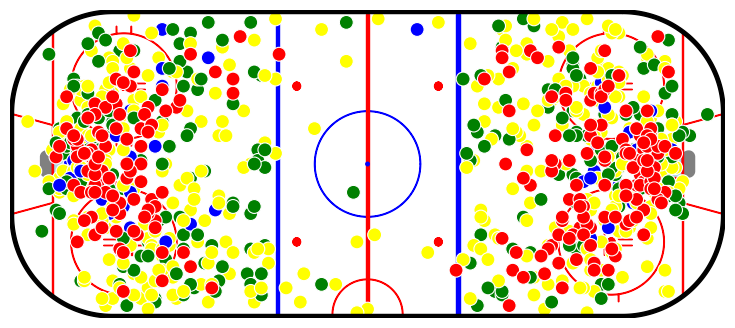

In [27]:
rink = NHLRink()

x = [35, 110]
y = [0, 0]

ax = rink.draw(figsize=(10, 4))

rink.plot_fn(
    sns.scatterplot,
    x="xCoord",
    y="yCoord",
    hue="typeDescKey",
    palette=("red", "blue", "green", "yellow"),
    data=recent_bruins_all_shots_against,
    s=100,
    legend=False,
    draw_kw={"figsize": (10, 4)},
)


plt.show()

In [28]:
recent_bruins_all_shots_against["game_id"].unique()

array(['2024020561', '2024020570', '2024020589', '2024020604',
       '2024020623', '2024020641', '2024020633', '2024020655',
       '2024020669', '2024020692', '2024020723', '2024020740',
       '2024020758'], dtype=object)

In [29]:
# # Precompute subsets by game_id
# subsets = {
#     game_id: recent_bruins_all_shots_against[
#         recent_bruins_all_shots_against["game_id"] == game_id
#     ]
#     for game_id in recent_bruins_all_shots_against["game_id"].unique()
# }

# # Get the number of unique types for the palette
# unique_types = recent_bruins_all_shots_against[
#     "typeDescKey"
# ].cat.categories  # Access categories via `.cat`
# palette = sns.color_palette(
#     "husl", len(unique_types)
# )  # Use the number of categories for the palette

# # Initialize the FacetGrid
# g = sns.FacetGrid(
#     recent_bruins_all_shots_against, col="game_id", col_wrap=2, height=7, aspect=1.4
# )

# # Define titles
# titles = [
#     "at Columbus",
#     "vs Columbus",
#     "at Washington",
#     "at NYR",
#     "at Toronto",
#     "vs NYI",
#     "vs Edmonton",
#     "at Tampa Bay",
#     "at Florida",
#     "vs Tampa Bay",
#     "at Ottawa",
#     "vs San Jose",
#     "at New Jersey",
# ]

# # Initialize the rink (assuming you have this class defined somewhere)
# rink = NHLRink(net={"visible": False})
# # Precompute subsets by game_id

# # Define titles with dynamic counts
# for ax, (game_id, title) in zip(g.axes.flatten(), zip(subsets.keys(), titles)):
#     subset = subsets[game_id]

#     # Calculate total count of shot attempts
#     total_shots = len(subset)

#     # Calculate count of shot-on-goal
#     shot_on_goal_count = subset[subset["typeDescKey"] == "shot-on-goal"].shape[0]

#     # Update title to include both counts
#     title_with_counts = f"{title}"

#     rink.draw(display_range="half", ax=ax)  # Draw rink once per axis
#     sns.scatterplot(
#         x="x_adjusted",
#         y="y_adjusted",
#         hue="typeDescKey",
#         palette=palette,
#         data=subset,
#         s=250,  # Adjusted marker size
#         ax=ax,
#         legend=False,  # Suppress individual legends
#     )

#     ax.set_title(title_with_counts, fontsize=16, pad=11)  # Title with no count
#     ax.set_xlabel("X Coordinate")
#     ax.set_ylabel("Y Coordinate")
#     ax.set_xlim([0, 100])
#     ax.set_ylim([-50, 50])

#     # Add the counts under the title
#     ax.text(
#         0.5,
#         0.95,  # X, Y position of the text (slightly above the plot area)
#         f"Total shot attempts: {total_shots} | Shot on goal: {shot_on_goal_count}",
#         ha="center",  # Horizontal alignment
#         va="bottom",  # Vertical alignment
#         transform=ax.transAxes,  # Use axes coordinates
#         fontsize=12,  # Font size
#         color="black",  # Color of the text
#     )


# # Create custom legend elements based on the ordered categories
# legend_elements = [
#     Line2D(
#         [0],
#         [0],
#         marker="o",
#         color="w",
#         label=type_,
#         markerfacecolor=color,
#         markersize=10,
#     )
#     for type_, color in zip(unique_types, palette)
# ]

# # Add the legend to the figure
# g.fig.legend(
#     handles=legend_elements,
#     loc="lower right",
#     bbox_to_anchor=(0.7, 0.1),
#     ncol=1,
#     fontsize=20,
#     markerscale=1.5,
#     frameon=True,
# )

# # Adjust layout to reduce white space and fit the legend
# plt.subplots_adjust(hspace=0.4, wspace=0.3, bottom=0.15, right=0.85)
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the legend

# # Display the plot
# plt.show()


In [30]:
# # Group the data by game_id and typeDescKey, then count occurrences
# grouped = (
#     # Explicitly set observed=True or observed=False based on your preference
#     bruins_all_shots_against.groupby(["game_id", "typeDescKey"], observed=False)
#     .size()
#     .unstack(fill_value=0)
# )

# # Plot a stacked bar chart
# grouped.plot(
#     kind="bar",
#     stacked=True,
#     figsize=(12, 6),
#     colormap="viridis",  # You can change the colormap if desired
# )

# # Customize the chart
# plt.title("Shot Attempts by Game ID and Category", fontsize=16)
# plt.xlabel("Game ID", fontsize=12)
# plt.ylabel("Total Shot Attempts", fontsize=12)
# plt.xticks(rotation=90, fontsize=10)
# plt.legend(title="Shot Attempt Type", fontsize=10, title_fontsize=12)
# plt.tight_layout()

# # Display the plot
# plt.show()


Grouped DataFrame with Rolling Average:
typeDescKey  blocked-shot  goal  missed-shot  shot-on-goal  total_shots  \
game_id                                                                   
2024020004              9     6           19            29           63   
2024020011             21     4           19            20           64   
2024020024             18     1           10            33           62   
2024020042              8     4            9            22           43   
2024020059             19     3           15            22           59   

typeDescKey  rolling_avg  
game_id                   
2024020004     63.000000  
2024020011     63.500000  
2024020024     63.000000  
2024020042     56.333333  
2024020059     54.666667  
Grouped DataFrame after reset_index:
typeDescKey     game_id  blocked-shot  goal  missed-shot  shot-on-goal  \
0            2024020004             9     6           19            29   
1            2024020011            21     4           19    

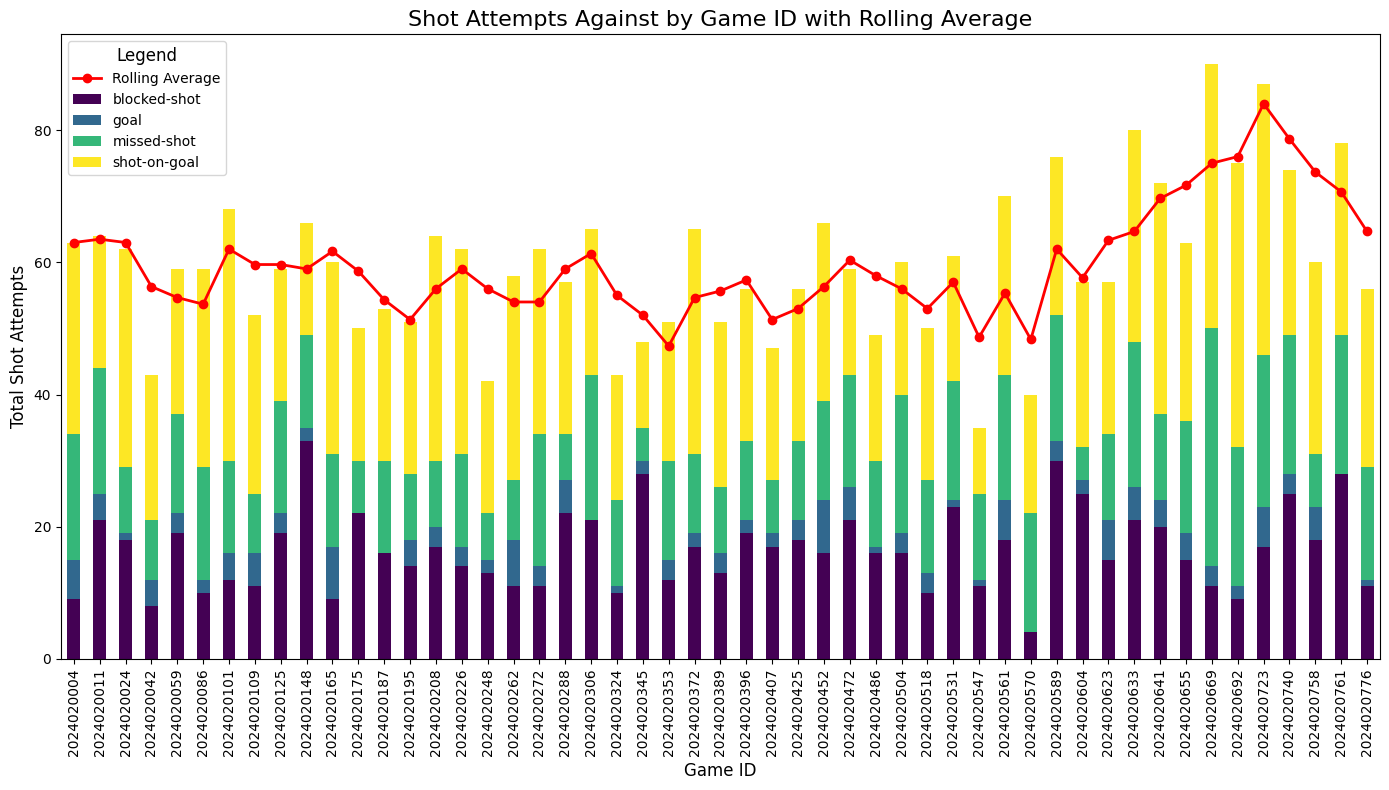

In [31]:
# # Group the data by game_id and typeDescKey, then count occurrences
# grouped = (
#     # Explicitly set observed=True or observed=False based on your preference
#     bruins_all_shots_against.groupby(["game_id", "typeDescKey"], observed=False)
#     .size()
#     .unstack(fill_value=0)
# )

# # Calculate the total shot attempts for each game_id
# grouped["total_shots"] = grouped.sum(axis=1)

# # Compute the rolling average of the total shots (adjust the window size as needed)
# grouped["rolling_avg"] = grouped["total_shots"].rolling(window=3, min_periods=1).mean()

# # Plot the stacked bar chart
# ax = grouped.drop(columns=["total_shots", "rolling_avg"]).plot(
#     kind="bar", stacked=True, figsize=(14, 8), colormap="viridis"
# )

# # Overlay the rolling average line
# ax.plot(
#     grouped.index,
#     grouped["rolling_avg"],
#     color="red",
#     marker="o",
#     linestyle="-",
#     linewidth=2,
#     label="Rolling Average",
# )

# # Customize the chart
# ax.set_title("Shot Attempts Against by Game ID with Rolling Average", fontsize=16)
# ax.set_xlabel("Game ID", fontsize=12)
# ax.set_ylabel("Total Shot Attempts", fontsize=12)
# ax.tick_params(axis="x", rotation=90, labelsize=10)
# ax.legend(title="Legend", fontsize=10, title_fontsize=12)
# plt.tight_layout()

# # Display the plot
# plt.show()

grouped = (
    bruins_all_shots_against.groupby(["game_id", "typeDescKey"], observed=False)
    .size()
    .unstack(fill_value=0)
)

# Calculate the total shot attempts
grouped["total_shots"] = grouped.sum(axis=1)

# Compute the rolling average
grouped["rolling_avg"] = grouped["total_shots"].rolling(window=3, min_periods=1).mean()

# Debugging: Print the DataFrame to verify
print("Grouped DataFrame with Rolling Average:")
print(grouped.head())

# Reset index to use "game_id" as a column for plotting
grouped = grouped.reset_index()

# Debugging: Ensure "game_id" is in the DataFrame
print("Grouped DataFrame after reset_index:")
print(grouped.head())

# Plot the stacked bar chart
ax = grouped.drop(columns=["total_shots", "rolling_avg"]).plot(
    kind="bar", x="game_id", stacked=True, figsize=(14, 8), colormap="viridis"
)

# Overlay the rolling average line
ax.plot(
    grouped["game_id"],  # Use the "game_id" column
    grouped["rolling_avg"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    label="Rolling Average",
    zorder=5,  # Ensure the line is above the bars
)

# Customize the chart
ax.set_title("Shot Attempts Against by Game ID with Rolling Average", fontsize=16)
ax.set_xlabel("Game ID", fontsize=12)
ax.set_ylabel("Total Shot Attempts", fontsize=12)
ax.tick_params(axis="x", rotation=90, labelsize=10)
ax.legend(title="Legend", fontsize=10, title_fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


In [32]:
# mean prior to game 20240623
prior_grouped = bruins_all_shots_against[
    ~bruins_all_shots_against["game_id"].isin(bruins_game_id)
]

prior_grouped = (
    prior_grouped.groupby(["game_id", "typeDescKey"], observed=False)
    .size()
    .unstack(fill_value=0)
)

# Calculate the total shot attempts for each game_id
prior_grouped["total_shots"] = prior_grouped.sum(axis=1)

# Compute the rolling average of the total shots (adjust the window size as needed)
prior_grouped["rolling_avg"] = (
    prior_grouped["total_shots"].rolling(window=3, min_periods=1).mean()
)


In [33]:
print(prior_grouped["total_shots"].mean())
print(prior_grouped["total_shots"].median())
print(prior_grouped["total_shots"].mode())

56.578947368421055
58.5
0    59
Name: total_shots, dtype: int64


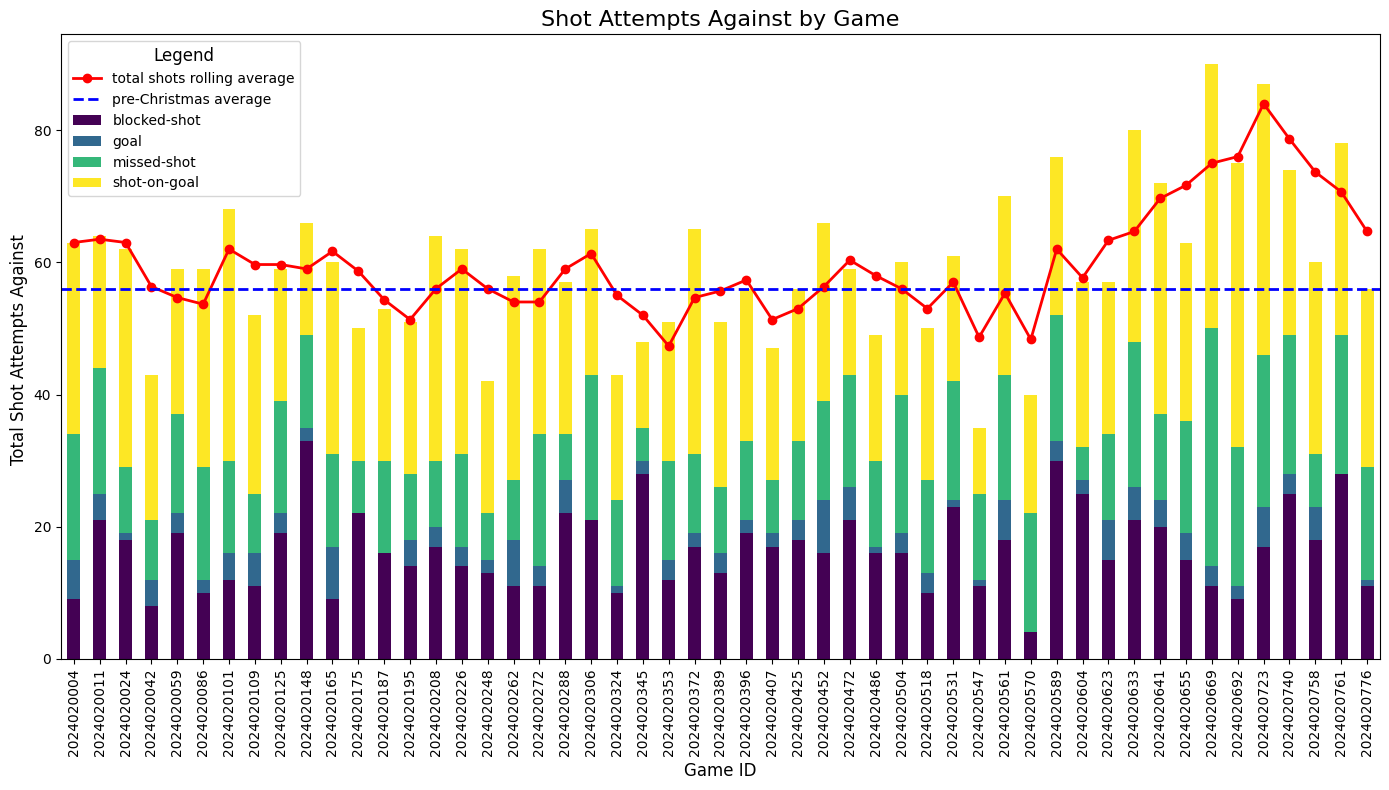

In [34]:
# Group the data by game_id and typeDescKey, then count occurrences
grouped = (
    # Explicitly set observed=True or observed=False based on your preference
    bruins_all_shots_against.groupby(["game_id", "typeDescKey"], observed=False)
    .size()
    .unstack(fill_value=0)
)

# Calculate the total shot attempts for each game_id
grouped["total_shots"] = grouped.sum(axis=1)

# Compute the rolling average of the total shots (adjust the window size as needed)
grouped["rolling_avg"] = grouped["total_shots"].rolling(window=3, min_periods=1).mean()

# Plot the stacked bar chart
ax = grouped.drop(columns=["total_shots", "rolling_avg"]).plot(
    kind="bar", stacked=True, figsize=(14, 8), colormap="viridis"
)

# Overlay the rolling average line
ax.plot(
    grouped.index,
    grouped["rolling_avg"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    label="total shots rolling average",
)

# Add horizontal line at y=56
ax.axhline(
    y=56, color="blue", linestyle="--", linewidth=2, label="pre-Christmas average"
)

# Customize the chart
ax.set_title("Shot Attempts Against by Game", fontsize=16)
ax.set_xlabel("Game ID", fontsize=12)
ax.set_ylabel("Total Shot Attempts Against ", fontsize=12)
ax.tick_params(axis="x", rotation=90, labelsize=10)
ax.legend(title="Legend", fontsize=10, title_fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


In [35]:
# mean prior to game 20240623
recent_grouped = bruins_all_shots_against[
    bruins_all_shots_against["game_id"].isin(bruins_game_id)
]

recent_grouped = (
    recent_grouped.groupby(["game_id", "typeDescKey"], observed=False)
    .size()
    .unstack(fill_value=0)
)

# Calculate the total shot attempts for each game_id
recent_grouped["total_shots"] = recent_grouped.sum(axis=1)

# Compute the rolling average of the total shots (adjust the window size as needed)
recent_grouped["rolling_avg"] = (
    recent_grouped["total_shots"].rolling(window=3, min_periods=1).mean()
)

recent_grouped

typeDescKey,blocked-shot,goal,missed-shot,shot-on-goal,total_shots,rolling_avg
game_id,,,,,,
2024020561,18,6,19,27,70,70.000000
2024020570,4,0,18,18,40,55.000000
2024020589,30,3,19,24,76,62.000000
2024020604,25,2,5,25,57,57.666667
2024020623,15,6,13,23,57,63.333333
2024020633,21,5,22,32,80,64.666667
2024020641,20,4,13,35,72,69.666667
2024020655,15,4,17,27,63,71.666667
2024020669,11,3,36,40,90,75.000000


In [36]:
prev_groupa["game_id"].unique()

NameError: name 'prev_groupa' is not defined

In [ ]:
# Group and calculate stats for recent data
recent_group = recent_bruins_all_shots_against[["typeDescKey", "game_id"]].groupby(
    "typeDescKey"
)
recent_counts = (
    recent_group["game_id"]
    .agg(
        total_count="size",
        unique_count="nunique",
    )
    .reset_index()
)
recent_counts["mean"] = recent_counts["total_count"] / recent_counts["unique_count"]

# Group and calculate stats for all data
all_group = bruins_all_shots_against[["typeDescKey", "game_id"]].groupby("typeDescKey")
all_counts = (
    all_group["game_id"]
    .agg(
        total_count="size",
        unique_count="nunique",
    )
    .reset_index()
)
all_counts["mean"] = all_counts["total_count"] / all_counts["unique_count"]

# Group and calculate stats for previous data
prev_groupa = bruins_all_shots_against[
    ~bruins_all_shots_against["game_id"].isin(bruins_game_id)
]
prev_group = prev_groupa[["typeDescKey", "game_id"]].groupby("typeDescKey")
prev_counts = (
    prev_group["game_id"]
    .agg(
        total_count="size",
        unique_count="nunique",
    )
    .reset_index()
)
prev_counts["mean"] = prev_counts["total_count"] / prev_counts["unique_count"]

# Add source labels for differentiation
recent_counts["source"] = "Recent"
all_counts["source"] = "All"
prev_counts["source"] = "Previous"

# Display each table separately


# Display Recent Data
print("### Recent Data ###")
print(recent_counts[["typeDescKey", "total_count", "unique_count", "mean"]])
print("\n" + "-" * 30 + "\n")

# Display All Data
print("### All Data ###")
print(all_counts[["typeDescKey", "total_count", "unique_count", "mean"]])
print("\n" + "-" * 30 + "\n")

# Display Previous Data
print("### Previous Data ###")
print(prev_counts[["typeDescKey", "total_count", "unique_count", "mean"]])


In [ ]:
# Group the data by game_id and typeDescKey, then count occurrences
grouped = (
    # Explicitly set observed=True or observed=False based on your preference
    recent_bruins_all_shots_against.groupby(["game_id", "typeDescKey"], observed=False)
    .size()
    .unstack(fill_value=0)
)

# Calculate the total shot attempts for each game_id
grouped["total_shots"] = grouped.sum(axis=1)

# Compute the rolling average of the total shots (adjust the window size as needed)
grouped["rolling_avg"] = grouped["total_shots"].rolling(window=3, min_periods=1).mean()

# Plot the stacked bar chart
ax = grouped.drop(columns=["total_shots", "rolling_avg"]).plot(
    kind="bar", stacked=True, figsize=(8, 8), colormap="viridis"
)

# Overlay the rolling average line
ax.plot(
    grouped.index,
    grouped["rolling_avg"],
    color="red",
    marker="o",
    linestyle="-",
    linewidth=2,
    label="total shots rolling average",
)

# Add horizontal line at y=56
ax.axhline(
    y=56, color="blue", linestyle="--", linewidth=2, label="pre-Christmas average"
)

# Customize the chart
ax.set_title("Shot Attempts Against by Game", fontsize=16)
ax.set_xlabel("Game ID", fontsize=12)
ax.set_ylabel("Total Shot Attempts Against", fontsize=12)
ax.tick_params(axis="x", rotation=90, labelsize=10)
ax.legend(title="Legend", fontsize=10, title_fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Round the 'mean' values for both the Recent and Previous groups
recent_counts["rounded_mean"] = round(recent_counts["mean"], 2)
prev_counts["rounded_mean"] = round(prev_counts["mean"], 2)

# Merge the two dataframes to get a combined table for plotting
merged_data = pd.merge(
    recent_counts[["typeDescKey", "rounded_mean"]].rename(
        columns={"rounded_mean": "recent_mean"}
    ),
    prev_counts[["typeDescKey", "rounded_mean"]].rename(
        columns={"rounded_mean": "previous_mean"}
    ),
    on="typeDescKey",
    how="inner",
)
merged_data

In [ ]:
# Round the 'mean' values for both the Recent and Previous groups
recent_counts["rounded_mean"] = round(recent_counts["mean"], 2)
prev_counts["rounded_mean"] = round(prev_counts["mean"], 2)

# Add a 'group' column to each DataFrame to indicate "recent" or "previous"
prev_counts["group"] = "Before Christmas"

recent_counts["group"] = "After Christmas"


# Combine the two DataFrames vertically
combined_data = pd.concat(
    [
        recent_counts[["group", "typeDescKey", "rounded_mean"]].rename(
            columns={"rounded_mean": "mean"}
        ),
        prev_counts[["group", "typeDescKey", "rounded_mean"]].rename(
            columns={"rounded_mean": "mean"}
        ),
    ],
    ignore_index=True,
)

# Pivot the DataFrame to make "typeDescKey" columns and "group" the index
pivoted_data = combined_data.pivot(
    index="group", columns="typeDescKey", values="mean"
).reset_index()

# Rename index column
pivoted_data = pivoted_data.rename_axis(None, axis=1)
pivoted_data = pivoted_data.sort_values(by="group", ascending=False)

pivoted_data


In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))

# Plot a line for each column (typeDescKey, e.g., A, B)
for column in pivoted_data.columns[1:]:  # Skip the 'group' column
    plt.plot(
        pivoted_data["group"],  # x-axis: 'group'
        pivoted_data[column],  # y-axis: values for each typeDescKey
        marker="o",
        label=column,  # Use typeDescKey as the label
    )

# Adjust x-axis to bring 'recent' and 'previous' closer
plt.xticks(range(len(pivoted_data["group"])), pivoted_data["group"], fontsize=10)
plt.xlim(-0.5, 1.7)  # Compress the range even more for tighter spacing

# Add labels, title, and legend
plt.xlabel("Time Period")
plt.ylabel("Average Count")
plt.title("Average Shots and Shot Attempts Against: Boston Bruins")
plt.legend(title="Shot/Shot Attempt Type", loc="best")
plt.grid(True)

# Show the plot
plt.show()


### All Other Teams

In [ ]:
all_shots_made.head()

In [ ]:
non_bruins_all_shots_made = all_shots_made[all_shots_made["event_team_id"] != 6]
non_bruins_all_shots_made["event_team_id"].unique()

In [ ]:
other_games = combined_df[
    (combined_df["awayTeam.id"] != 6) | (combined_df["homeTeam.id"] != 6)
]


other_games["game_date"] = pd.to_datetime(other_games["game_date"], format="%Y-%m-%d")

start_date = pd.to_datetime("2024-12-26", format="%Y-%m-%d")
end_date = pd.to_datetime("2025-01-22", format="%Y-%m-%d")

# Filter the DataFrame
recent_other_games = other_games[
    (other_games["game_date"] >= start_date) & (other_games["game_date"] <= end_date)
]
other_games.head()


In [ ]:
recent_other_games.head()

In [ ]:
other_games = other_games[["game_id", "awayTeam.id", "homeTeam.id"]]

non_bruins_all_shots_made = non_bruins_all_shots_made.merge(
    other_games, on="game_id", how="left"
)
non_bruins_all_shots_made.head()

In [ ]:
recent_game_ids = recent_other_games["game_id"]

# Filter the DataFrame

recent_games = non_bruins_all_shots_made[
    non_bruins_all_shots_made["game_id"].isin(recent_game_ids)
]

previous_other_games = non_bruins_all_shots_made[
    ~non_bruins_all_shots_made["game_id"].isin(recent_game_ids)
]

previous_other_games.head()

In [ ]:
recent_games.head()

In [ ]:
# Group and calculate stats for recent data
recent_group = recent_games[["typeDescKey", "game_id"]].groupby("typeDescKey")
recent_counts = (
    recent_group["game_id"]
    .agg(
        total_count="size",
        unique_count="nunique",
    )
    .reset_index()
)
recent_counts["mean"] = recent_counts["total_count"] / recent_counts["unique_count"]

# # Group and calculate stats for all data
# all_group = bruins_all_shots_against[["typeDescKey", "game_id"]].groupby("typeDescKey")
# all_counts = (
#     all_group["game_id"]
#     .agg(
#         total_count="size",
#         unique_count="nunique",
#     )
#     .reset_index()
# )
# all_counts["mean"] = all_counts["total_count"] / all_counts["unique_count"]

# Group and calculate stats for previous data
# prev_groupa = bruins_all_shots_against[
#     ~bruins_all_shots_against["game_id"].isin(bruins_game_id)
# ]
prev_group = previous_other_games[["typeDescKey", "game_id"]].groupby("typeDescKey")
prev_counts = (
    prev_group["game_id"]
    .agg(
        total_count="size",
        unique_count="nunique",
    )
    .reset_index()
)
prev_counts["mean"] = prev_counts["total_count"] / prev_counts["unique_count"]

# Add source labels for differentiation
recent_counts["source"] = "Recent"
all_counts["source"] = "All"
prev_counts["source"] = "Previous"


# Display Recent Data
print("### Recent Data ###")
print(recent_counts[["typeDescKey", "total_count", "unique_count", "mean"]])
print("\n" + "-" * 30 + "\n")

# Display All Data
print("### All Data ###")
print(all_counts[["typeDescKey", "total_count", "unique_count", "mean"]])
print("\n" + "-" * 30 + "\n")

# Display Previous Data
print("### Previous Data ###")
print(prev_counts[["typeDescKey", "total_count", "unique_count", "mean"]])


In [ ]:
# Round the 'mean' values for both the Recent and Previous groups
recent_counts["rounded_mean"] = round(recent_counts["mean"], 2)
prev_counts["rounded_mean"] = round(prev_counts["mean"], 2)

# Merge the two dataframes to get a combined table for plotting
merged_data = pd.merge(
    recent_counts[["typeDescKey", "rounded_mean"]].rename(
        columns={"rounded_mean": "recent_mean"}
    ),
    prev_counts[["typeDescKey", "rounded_mean"]].rename(
        columns={"rounded_mean": "previous_mean"}
    ),
    on="typeDescKey",
    how="inner",
)
merged_data

In [ ]:
# Round the 'mean' values for both the Recent and Previous groups
recent_counts["rounded_mean"] = round(recent_counts["mean"], 2)
prev_counts["rounded_mean"] = round(prev_counts["mean"], 2)

# Add a 'group' column to each DataFrame to indicate "recent" or "previous"
recent_counts["group"] = "After Christmas"
prev_counts["group"] = "Before Christmas"

# Combine the two DataFrames vertically
combined_data = pd.concat(
    [
        recent_counts[["group", "typeDescKey", "rounded_mean"]].rename(
            columns={"rounded_mean": "mean"}
        ),
        prev_counts[["group", "typeDescKey", "rounded_mean"]].rename(
            columns={"rounded_mean": "mean"}
        ),
    ],
    ignore_index=True,
)

# Pivot the DataFrame to make "typeDescKey" columns and "group" the index
pivoted_data = combined_data.pivot(
    index="group", columns="typeDescKey", values="mean"
).reset_index()

# Rename index column
pivoted_data = pivoted_data.rename_axis(None, axis=1)

pivoted_data = pivoted_data.sort_values(by="group", ascending=False)
pivoted_data


In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))

# Plot a line for each column (typeDescKey, e.g., A, B)
for column in pivoted_data.columns[1:]:  # Skip the 'group' column
    plt.plot(
        pivoted_data["group"],  # x-axis: 'group'
        pivoted_data[column],  # y-axis: values for each typeDescKey
        marker="o",
        label=column,  # Use typeDescKey as the label
    )

# Adjust x-axis to bring 'recent' and 'previous' closer
plt.xticks(range(len(pivoted_data["group"])), pivoted_data["group"], fontsize=10)
plt.xlim(-0.5, 1.7)  # Compress the range even more for tighter spacing

# Add labels, title, and legend
plt.xlabel("Time Period")
plt.ylabel("Average Counts")
plt.title("Average Shots and Shot Attempts Against: Rest of the League")
plt.legend(title="Shot/Shot Attempt Type", loc="best")
plt.grid(True)

# Show the plot
plt.show()
